In [ ]:
# Created by: Jess Gallo
# Date Created: 08/08/2022
# Last Modified: 08/08/2022
# Description: Data Scientist Technical Skills Assessment
# CSP Informatics Center, VA Boston Healthcare System

# This is a classification problem (Outcome: Dead or Alive)

In [55]:
# Libraries
import pandas as pd
import fuzzywuzzy
from fuzzywuzzy import process
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import  LinearDiscriminantAnalysis
from sklearn.naive_bayes import  GaussianNB
from sklearn.svm import  SVC
import warnings

In [2]:
# Import csv
filename = pd.read_csv(r"C:\Users\Gallo\Downloads\Data_Scientist_Exercise\clinical.csv", index_col=0)
df = pd.DataFrame(filename)

df.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations
ID,,,,,,,,,,,,,,,
1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8
2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2
3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1
4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4
5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 1 to 190
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Outcome            190 non-null    object 
 1   Survival.Months    190 non-null    float64
 2   Age                190 non-null    int64  
 3   Grade              190 non-null    int64  
 4   Num.Primaries      190 non-null    int64  
 5   T                  190 non-null    object 
 6   N                  125 non-null    float64
 7   M                  94 non-null     float64
 8   Radiation          190 non-null    int64  
 9   Stage              190 non-null    object 
 10  Primary.Site       190 non-null    object 
 11  Histology          190 non-null    object 
 12  Tumor.Size         98 non-null     float64
 13  Num.Mutated.Genes  190 non-null    int64  
 14  Num.Mutations      190 non-null    int64  
dtypes: float64(4), int64(6), object(5)
memory usage: 23.8+ KB


In [4]:
df.describe()

,Survival.Months,Age,Grade,Num.Primaries,N,M,Radiation,Tumor.Size,Num.Mutated.Genes,Num.Mutations
count,190.000000,190.000000,190.000000,190.000000,125.000000,94.000000,190.000000,98.000000,190.000000,190.000000
mean,22.186842,70.173684,6.105263,0.226316,1.144000,0.085106,1.657895,4.494898,2.684211,3.084211
std,12.420140,6.146909,2.995495,0.419551,1.029438,0.280536,2.360122,3.050988,1.460327,1.697575
min,9.000000,56.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000
25%,11.000000,67.000000,3.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000
50%,16.000000,71.000000,9.000000,0.000000,2.000000,0.000000,0.000000,3.600000,3.000000,3.000000
75%,34.000000,74.000000,9.000000,0.000000,2.000000,0.000000,5.000000,8.000000,3.000000,4.000000
max,71.000000,84.000000,9.000000,1.000000,3.000000,1.000000,5.000000,10.000000,8.000000,8.000000


# Data Cleaning

Checking categorical columns for inconsistent data entry.

In [5]:
stage = df['Stage'].unique()
stage.sort()
stage

array(['1B', 'IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV', 'IVB'],
      dtype=object)

In [6]:
df.groupby('Stage').size()

Stage
1B       1
IA      32
IB       1
IIA      8
IIB     11
IIIA    43
IIIB    24
IV      45
IVB     25
dtype: int64

Based on the data, I believe that the unique value '1B' is a mistake that should be changed to IB.

In [7]:
df['Stage'] = df['Stage'].replace(['1B'], 'IB')

In [8]:
stage = df['Stage'].unique()
stage.sort()
stage

array(['IA', 'IB', 'IIA', 'IIB', 'IIIA', 'IIIB', 'IV', 'IVB'],
      dtype=object)

In [9]:
site = df['Primary.Site'].unique()
site.sort()
site

array(['Both Lung', 'Left Hilar', 'Left Lower Lobe', 'Left Upper Lobe',
       'Righ Upper Lobe', 'Right Hilar', 'Right Lower Lobe',
       'Right Middle Lobe', 'Right Upper Lobe'], dtype=object)

There is a spelling error that creates 2 separate values for Right Upper Lobe. We can use Fuzzywuzzy to fix this.

In [10]:
# get the top 2 closest matches to "Right Upper Lobe"
matches = fuzzywuzzy.process.extract('Right Upper Lobe', site, limit=2, scorer=fuzzywuzzy.fuzz.token_sort_ratio)
matches

[('Right Upper Lobe', 100), ('Righ Upper Lobe', 97)]

In [11]:
# replaces rows with what we need from matches above
def replace_matches_in_column(df, column, string_to_match, min_ratio = 97):
    strings = df[column].unique()
    
    # get the top 2 closest matches to our input string
    matches = fuzzywuzzy.process.extract(string_to_match, strings, limit=2, scorer=fuzzywuzzy.fuzz.token_sort_ratio)

    # only get matches with a ratio > 90
    close_matches = [matches[0] for matches in matches if matches[1] >= min_ratio]

    # get the rows of all the close matches in our dataframe
    rows_with_matches = df[column].isin(close_matches)

    # replace all rows with close matches with the input matches 
    df.loc[rows_with_matches, column] = string_to_match
    
    # let us know the function's done
    print('Done')

In [12]:
replace_matches_in_column(df=df, column='Primary.Site', string_to_match='Right Upper Lobe')

Done


In [13]:
site = df['Primary.Site'].unique()
site

array(['Left Lower Lobe', 'Right Upper Lobe', 'Left Hilar', 'Right Hilar',
       'Left Upper Lobe', 'Right Lower Lobe', 'Both Lung',
       'Right Middle Lobe'], dtype=object)

The column T has an UNK (Null) value. Left it for now, but might change it to NaN and Impute data

In [ ]:
t = df['T'].unique()
t.sort()
t

Checking for missing data.

In [14]:
df.isnull().any()

Outcome              False
Survival.Months      False
Age                  False
Grade                False
Num.Primaries        False
T                    False
N                     True
M                     True
Radiation            False
Stage                False
Primary.Site         False
Histology            False
Tumor.Size            True
Num.Mutated.Genes    False
Num.Mutations        False
dtype: bool

There is missing data in columns 'N', 'M' and 'Tumor.Size'. Since there is a lot of data missing from 

In [15]:
missing_columns = ['N', 'M', 'Tumor.Size']

def random_imputation(df, feature):
    number_missing = df[feature].isnull().sum()
    observed_values = df.loc[df[feature].notnull(), feature]
    df.loc[df[feature].isnull(), feature + '_imp'] = np.random.choice(observed_values, number_missing, replace = True)
    return df

for feature in missing_columns:
    df[feature + '_imp'] = df[feature]
    df = random_imputation(df, feature)

df.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,N,M,Radiation,Stage,Primary.Site,Histology,Tumor.Size,Num.Mutated.Genes,Num.Mutations,N_imp,M_imp,Tumor.Size_imp
ID,,,,,,,,,,,,,,,,,,
1,Alive,9.0,67,4,0,UNK,2.0,NaN,0,IV,Left Lower Lobe,Squamous cell carcinoma,1.4,8,8,2.0,0.0,1.4
2,Dead,19.0,73,2,0,UNK,2.0,0.0,5,IV,Right Upper Lobe,Adenocarcinoma,NaN,2,2,2.0,0.0,2.0
3,Dead,13.0,72,3,0,2,2.0,0.0,0,IIIA,Right Upper Lobe,Adenocarcinoma,1.5,1,1,2.0,0.0,1.5
4,Dead,15.0,69,9,1,1a,0.0,1.0,0,IA,Right Upper Lobe,Adenocarcinoma,NaN,4,4,0.0,1.0,3.6
5,Dead,10.0,76,9,0,UNK,NaN,NaN,0,IIIA,Left Hilar,Large-cell carcinoma,NaN,3,3,0.0,0.0,9.0


Now that we have the imputed data, we can drop the columns with NaN values and leave the imputed columns

In [16]:
df.drop(['N', 'M', 'Tumor.Size'], axis=1, inplace=True)
df.head()

,Outcome,Survival.Months,Age,Grade,Num.Primaries,T,Radiation,Stage,Primary.Site,Histology,Num.Mutated.Genes,Num.Mutations,N_imp,M_imp,Tumor.Size_imp
ID,,,,,,,,,,,,,,,
1,Alive,9.0,67,4,0,UNK,0,IV,Left Lower Lobe,Squamous cell carcinoma,8,8,2.0,0.0,1.4
2,Dead,19.0,73,2,0,UNK,5,IV,Right Upper Lobe,Adenocarcinoma,2,2,2.0,0.0,2.0
3,Dead,13.0,72,3,0,2,0,IIIA,Right Upper Lobe,Adenocarcinoma,1,1,2.0,0.0,1.5
4,Dead,15.0,69,9,1,1a,0,IA,Right Upper Lobe,Adenocarcinoma,4,4,0.0,1.0,3.6
5,Dead,10.0,76,9,0,UNK,0,IIIA,Left Hilar,Large-cell carcinoma,3,3,0.0,0.0,9.0


In [17]:
df.isnull().any()

Outcome              False
Survival.Months      False
Age                  False
Grade                False
Num.Primaries        False
T                    False
Radiation            False
Stage                False
Primary.Site         False
Histology            False
Num.Mutated.Genes    False
Num.Mutations        False
N_imp                False
M_imp                False
Tumor.Size_imp       False
dtype: bool

# Data Visualization

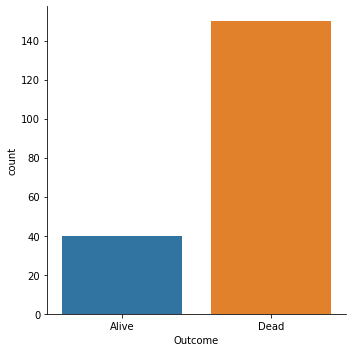

In [18]:
sns.catplot(x='Outcome', kind='count', data=df)

In [19]:
df2 = df.drop(['Outcome', 'Stage', 'Primary.Site', 'Histology', 'T'], axis=1)

df2.head()

,Survival.Months,Age,Grade,Num.Primaries,Radiation,Num.Mutated.Genes,Num.Mutations,N_imp,M_imp,Tumor.Size_imp
ID,,,,,,,,,,
1,9.0,67,4,0,0,8,8,2.0,0.0,1.4
2,19.0,73,2,0,5,2,2,2.0,0.0,2.0
3,13.0,72,3,0,0,1,1,2.0,0.0,1.5
4,15.0,69,9,1,0,4,4,0.0,1.0,3.6
5,10.0,76,9,0,0,3,3,0.0,0.0,9.0


<AxesSubplot:>

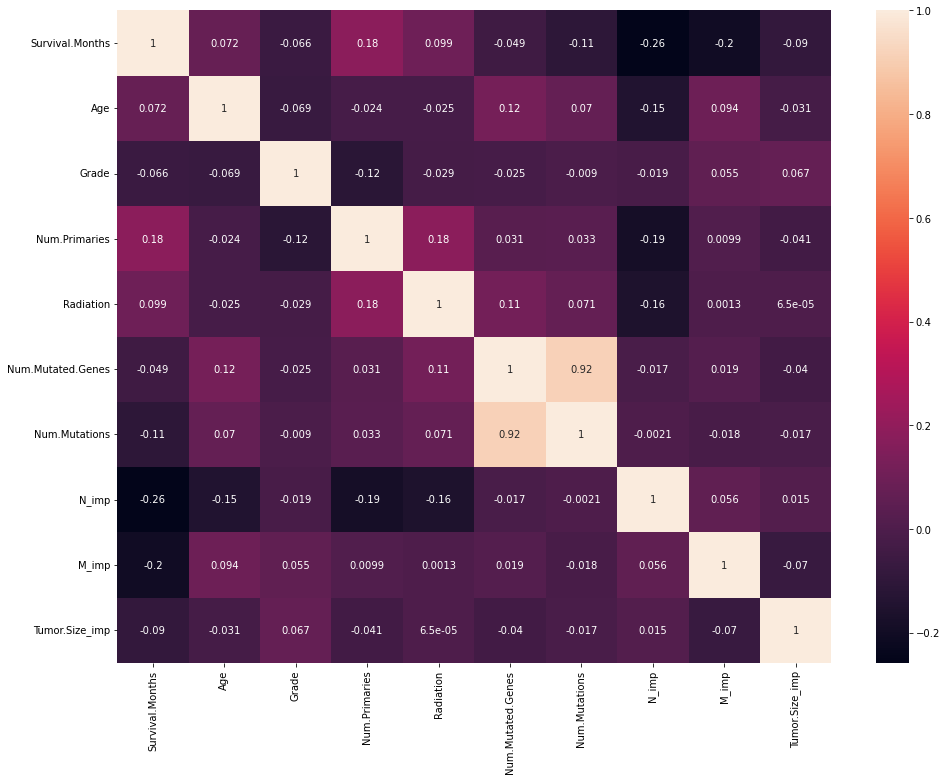

In [20]:
plt.figure(figsize=(16,12))
sns.heatmap(df2.corr(), annot=True)

Survival Months and Number of Primary Tumors are highly correlated, and so is Radiation treatment with Number of Primary Tumors.

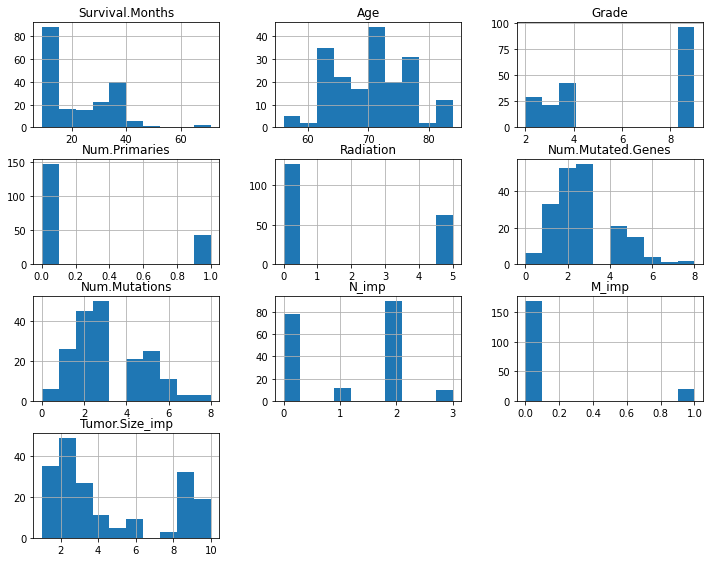

In [21]:
df.hist(layout= (5,3),figsize=(12,12))
plt.show()

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 190 entries, 1 to 190
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Outcome            190 non-null    object 
 1   Survival.Months    190 non-null    float64
 2   Age                190 non-null    int64  
 3   Grade              190 non-null    int64  
 4   Num.Primaries      190 non-null    int64  
 5   T                  190 non-null    object 
 6   Radiation          190 non-null    int64  
 7   Stage              190 non-null    object 
 8   Primary.Site       190 non-null    object 
 9   Histology          190 non-null    object 
 10  Num.Mutated.Genes  190 non-null    int64  
 11  Num.Mutations      190 non-null    int64  
 12  N_imp              190 non-null    float64
 13  M_imp              190 non-null    float64
 14  Tumor.Size_imp     190 non-null    float64
dtypes: float64(4), int64(6), object(5)
memory usage: 27.8+ KB


In [ ]:
sns.boxplot(x="N", y="N_imp", data=df)

# Data Preprocessing

There are different measurements for each column, so we need to standardize the data to accuratly be able to 

Categorical Data to numerical data

In [28]:
# make_column_transformer is OneHotEncoding for multiple columns
transformer = make_column_transformer((OneHotEncoder(), 
                                       ['Outcome', 'T', 'Stage', 'Primary.Site', 'Histology']),
                                      remainder='passthrough')
transformed = transformer.fit_transform(df)
transformed_df = pd.DataFrame(transformed, columns=transformer.get_feature_names())

print(transformed_df.head())

   onehotencoder__x0_Alive  onehotencoder__x0_Dead  onehotencoder__x1_1  \
0                      1.0                     0.0                  0.0   
1                      0.0                     1.0                  0.0   
2                      0.0                     1.0                  0.0   
3                      0.0                     1.0                  0.0   
4                      0.0                     1.0                  0.0   

   onehotencoder__x1_1a  onehotencoder__x1_1b  onehotencoder__x1_2  \
0                   0.0                   0.0                  0.0   
1                   0.0                   0.0                  0.0   
2                   0.0                   0.0                  1.0   
3                   1.0                   0.0                  0.0   
4                   0.0                   0.0                  0.0   

   onehotencoder__x1_2a  onehotencoder__x1_2b  onehotencoder__x1_3  \
0                   0.0                   0.0             

In [29]:
transformed_df.shape

(190, 40)

Feature Scaling with Normalization

Tried using MinMaxScaler() to normalize data, but gave slightly worse results.

# Data Modeling

In [68]:
# Split-out validation dataset
array = transformed_df.values
X = array[:,2:40]
Y = array[:,0:2]
validation_size = 0.20
seed = 0
X_train, X_validation, Y_train, Y_validation = train_test_split(X,Y,test_size=validation_size, random_state=seed)

# Verify shape of trainers and validators
print(X_train.shape)
print(X_validation.shape)
print(Y_train.shape)
print(Y_validation.shape)

(152, 38)
(38, 38)
(152, 2)
(38, 2)


In [69]:
# Spot-Check Algorithms
warnings.filterwarnings('ignore')
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))
# evaluate each model in turn
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=10, random_state=seed)
    cv_results = cross_val_score(model, X_train, Y_train, cv=kfold, scoring='accuracy')
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: nan (nan)
LDA: nan (nan)
KNN: 0.809167 (0.078634)
CART: 0.875417 (0.089490)
NB: nan (nan)
SVM: nan (nan)


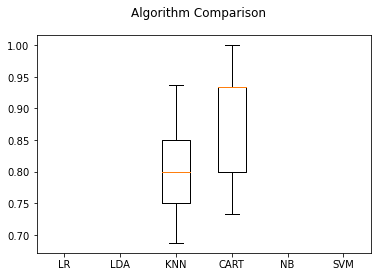

In [70]:
#Compare Algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

In [73]:
# Make predictions on validation dataset using DecisionTreeClassifier() Algorithm
knn = DecisionTreeClassifier()
knn.fit(X_train, Y_train)
predictions = knn.predict(X_validation)

#Accuracy Score
print('Accuracy SCore: ', accuracy_score(Y_validation, predictions))

# Classification report
print('Classification Report: \n', classification_report(Y_validation, predictions))

Accuracy SCore:  0.8947368421052632
Classification Report: 
               precision    recall  f1-score   support

           0       0.83      0.62      0.71         8
           1       0.91      0.97      0.94        30

   micro avg       0.89      0.89      0.89        38
   macro avg       0.87      0.80      0.82        38
weighted avg       0.89      0.89      0.89        38
 samples avg       0.89      0.89      0.89        38



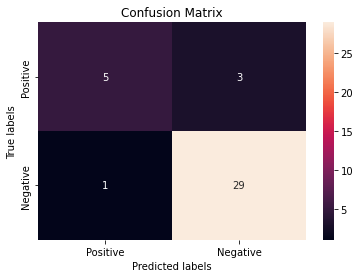

In [74]:
lables = ['Positive','Negative']

ax= plt.subplot()

cm = confusion_matrix(np.asarray(Y_validation).argmax(axis=1), np.asarray(predictions).argmax(axis=1))
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');
ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(lables); 
ax.yaxis.set_ticklabels(lables);